In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import sys
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import keras
import tensorflow as tf
import cv2
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam

In [2]:
directory = os.path.join('./data/face_extraction/')
img_height = 32
img_width = 32
batch_size = 32
nb_epochs = 100

print(directory)

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    directory,
    follow_links=True,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    directory, # same directory as training data
    follow_links=True,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

./data/face_extraction/
Found 1592 images belonging to 2 classes.
Found 397 images belonging to 2 classes.


In [3]:
learning_rate = 0.001

x = Input(shape = (img_width, img_height, 3))

x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

y = Flatten()(x4)
y = Dropout(0.5)(y)
y = Dense(16)(y)
y = LeakyReLU(alpha=0.1)(y)
y = Dropout(0.5)(y)
y = Dense(1, activation = 'sigmoid')(y)

model =  KerasModel(inputs = x, outputs = y)

optimizer = Adam(learning_rate = learning_rate)
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

In [4]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs)

Epoch 1/100
49/49 [==============================] - 13s 116ms/step - loss: 0.3838 - accuracy: 0.5244 - val_loss: 0.2526 - val_accuracy: 0.5286
Epoch 2/100
49/49 [==============================] - 4s 75ms/step - loss: 0.3293 - accuracy: 0.5538 - val_loss: 0.2937 - val_accuracy: 0.5000
Epoch 3/100
49/49 [==============================] - 4s 73ms/step - loss: 0.2803 - accuracy: 0.6071 - val_loss: 0.3780 - val_accuracy: 0.5000
Epoch 4/100
49/49 [==============================] - 4s 71ms/step - loss: 0.2811 - accuracy: 0.6019 - val_loss: 0.4272 - val_accuracy: 0.5000
Epoch 5/100
49/49 [==============================] - 4s 87ms/step - loss: 0.2584 - accuracy: 0.6263 - val_loss: 0.4483 - val_accuracy: 0.4974
Epoch 6/100
49/49 [==============================] - 4s 87ms/step - loss: 0.2543 - accuracy: 0.6365 - val_loss: 0.4602 - val_accuracy: 0.5078
Epoch 7/100
49/49 [==============================] - 4s 79ms/step - loss: 0.2447 - accuracy: 0.6449 - val_loss: 0.4561 - val_accuracy: 0.5000
Epoc

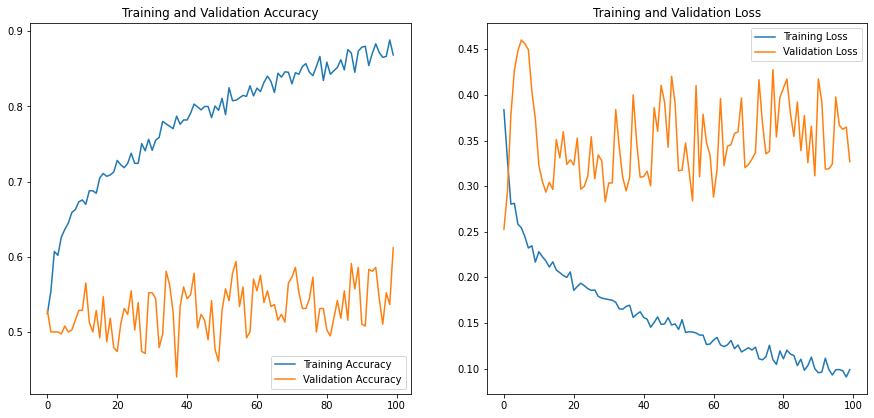

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(nb_epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [6]:
max_acc = max(acc)
mean_acc = np.mean(acc)

max_validation = max(val_acc)
mean_validation = np.mean(val_acc)

max_loss = max(loss)
mean_loss = np.mean(loss)

max_loss_validation = max(val_loss)
mean_loss_validation = np.mean(val_loss)

print('Max accuracy test:', max_acc)
print('Max accuracy test epoch:', acc.index(max_acc))
print('Mean accuracy test:', mean_acc)
print('Max accuracy validation:', max_validation)
print('Max accuracy validation epoch:', val_acc.index(max_validation))
print('Mean accuracy validation:', mean_validation)
print('Max loss test:', max_loss)
print('Max loss test epoch:', loss.index(max_loss))
print('Mean loss test:', mean_loss)
print('Max loss validation:', max_loss_validation)


Max accuracy test: 0.8884615302085876
Max accuracy test epoch: 98
Mean accuracy test: 0.7836474335193634
Max accuracy validation: 0.6119791865348816
Max accuracy validation epoch: 99
Mean accuracy validation: 0.5305729171633721
Max loss test: 0.38377028703689575
Max loss test epoch: 0
Mean loss test: 0.1574423985183239
Max loss validation: 0.4601571559906006
